# Untitled Notebook

What's this notebook about?

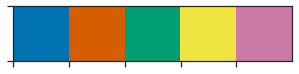

In [1]:
import re
import html
import sys
import os
from glob import glob
import random
from collections import Counter, defaultdict
import itertools as it

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib_venn as vn
from matplotlib.colors import ListedColormap
import seaborn as sns


## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=1.4, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [2]:
RESULTS_COLUMNS = [
    'chrom', 'start', 'end', 'locus_id', 'score', 'strand',
    'cpm', 'logfc', 'pval', 'fdr', 'gene_level_fdr'
]

fpa_vs_col0_regions = pd.read_csv(
    '../pipeline/differential_expression/dexseq_er_counts/fpa8_vs_col0.tsv',
    sep='\t',
    names=RESULTS_COLUMNS
).dropna()
fpa_vs_col0_regions['direction'] = fpa_vs_col0_regions.logfc < 0
fpa_vs_col0_regions['effect_size'] = fpa_vs_col0_regions.logfc.abs()
fpa_vs_col0_regions = fpa_vs_col0_regions.sort_values('effect_size', ascending=False).drop_duplicates([
    'locus_id', 'direction'
])

FPAox_vs_col0_regions = pd.read_csv(
    '../pipeline/differential_expression/dexseq_er_counts/35SFPA_vs_col0.tsv',
    sep='\t',
    names=RESULTS_COLUMNS
).dropna()
FPAox_vs_col0_regions['direction'] = FPAox_vs_col0_regions.logfc < 0
FPAox_vs_col0_regions['effect_size'] = FPAox_vs_col0_regions.logfc.abs()
FPAox_vs_col0_regions = FPAox_vs_col0_regions.sort_values('effect_size', ascending=False).drop_duplicates([
    'locus_id', 'direction'
])

FPAox_vs_col0_regions.head()

/cluster/ggs_lab/mtparker/.conda/envs/nb_bio/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,chrom,start,end,locus_id,score,strand,cpm,logfc,pval,fdr,gene_level_fdr,direction,effect_size
16967,1,17678357,17678470,RLOC_00005044,.,-,3.56,16.9047,1.134000e-10,4.318000e-08,0.000000,False,16.9047
59865,3,7375049,7375312,RLOC_00017151,.,-,11.24,-16.4323,8.070000e-25,2.039000e-21,0.000000,True,16.4323
115494,5,24688748,24688940,RLOC_00034283,.,-,8.47,16.0590,3.126000e-21,5.017000e-18,0.000000,False,16.0590
98786,5,5782636,5782940,RLOC_00029048,.,+,11.67,-16.0537,2.319000e-20,3.358000e-17,0.000000,True,16.0537
96497,5,4211301,4211418,RLOC_00028548,.,+,3.12,15.9329,8.041000e-07,8.959000e-05,0.000013,False,15.9329


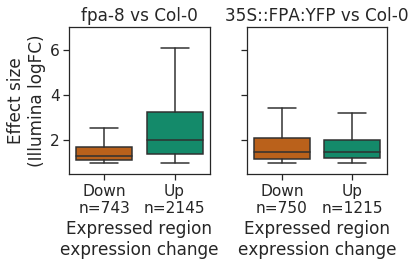

In [3]:
fig, axes = plt.subplots(figsize=(6, 4), ncols=2, sharey=True)

fpa_sig_regions = fpa_vs_col0_regions.query('fdr < 0.05 & gene_level_fdr < 0.05 & abs(logfc) > 1').copy()
FPAox_sig_regions = FPAox_vs_col0_regions.query('fdr < 0.05 & gene_level_fdr < 0.05 & abs(logfc) > 1').copy()

sns.boxplot(
    x=fpa_sig_regions.logfc > 0,
    y=fpa_sig_regions.logfc.abs(),
    ax=axes[0],
    palette=pal[1:3],
    fliersize=0
)

sns.boxplot(
    x=FPAox_sig_regions.logfc > 0,
    y=FPAox_sig_regions.logfc.abs(),
    ax=axes[1],
    palette=pal[1:3],
    fliersize=0
)

axes[0].set_title('fpa-8 vs Col-0')
axes[1].set_title('35S::FPA:YFP vs Col-0')
axes[0].set_ylim(0.5, 7)
axes[0].set_ylabel('Effect size\n(Illumina logFC)')
axes[1].set_ylabel('')
axes[0].set_xticklabels([f'Down\nn={len(fpa_sig_regions.query("logfc < 0"))}',
                         f'Up\nn={len(fpa_sig_regions.query("logfc > 0"))}'])
axes[1].set_xticklabels([f'Down\nn={len(FPAox_sig_regions.query("logfc < 0"))}',
                         f'Up\nn={len(FPAox_sig_regions.query("logfc > 0"))}'])
axes[0].set_xlabel('Expressed region\nexpression change')
axes[1].set_xlabel('Expressed region\nexpression change')
plt.tight_layout()
plt.savefig('Illumina_differentially_expressed_regions.svg')
plt.show()

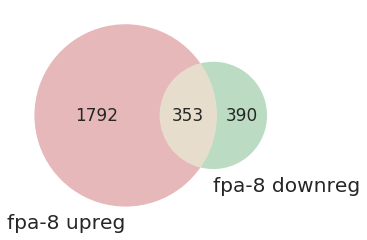

In [18]:
fpa_up = set(fpa_sig_regions.query('logfc > 0').locus_id)
fpa_down = set(fpa_sig_regions.query('logfc < 0').locus_id)
vn.venn2([fpa_up, fpa_down], ['fpa-8 upreg', 'fpa-8 downreg'])
plt.show()

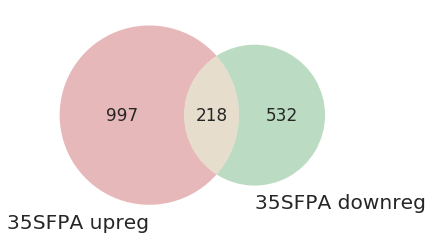

In [20]:
FPAox_up = set(FPAox_sig_regions.query('logfc > 0').locus_id)
FPAox_down = set(FPAox_sig_regions.query('logfc < 0').locus_id)
vn.venn2([FPAox_up, FPAox_down], ['35SFPA upreg', '35SFPA downreg'])
plt.show()

In [39]:
RESULTS_COLUMNS = [
    'chrom', 'start', 'end', 'locus_id', 'score', 'strand',
    'cpm', 'logfc', 'pval', 'fdr', 'gene_level_fdr'
]

fpa_vs_col0_junc = pd.read_csv(
    '../pipeline/differential_expression/dexseq_junc_counts/fpa8_vs_col0.tsv',
    sep='\t',
    names=RESULTS_COLUMNS
).dropna()
fpa_vs_col0_junc['direction'] = fpa_vs_col0_junc.logfc < 0
fpa_vs_col0_junc['effect_size'] = fpa_vs_col0_junc.logfc.abs()
fpa_vs_col0_junc = fpa_vs_col0_junc.sort_values('effect_size', ascending=False).drop_duplicates([
    'locus_id', 'direction'
])

FPAox_vs_col0_junc = pd.read_csv(
    '../pipeline/differential_expression/dexseq_junc_counts/35SFPA_vs_col0.tsv',
    sep='\t',
    names=RESULTS_COLUMNS
).dropna()
FPAox_vs_col0_junc['direction'] = FPAox_vs_col0_junc.logfc < 0
FPAox_vs_col0_junc['effect_size'] = FPAox_vs_col0_junc.logfc.abs()
FPAox_vs_col0_junc = FPAox_vs_col0_junc.sort_values('effect_size', ascending=False).drop_duplicates([
    'locus_id', 'direction'
])

FPAox_vs_col0_junc.head()

/cluster/ggs_lab/mtparker/.conda/envs/nb_bio/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,chrom,start,end,locus_id,score,strand,cpm,logfc,pval,fdr,gene_level_fdr,direction,effect_size
112814,4,10897794,10898448,RLOC_00024828,.,+,50.08,23.5023,3.838000e-103,3.727000e-98,0.00000,False,23.5023
124891,4,17896742,17897120,RLOC_00026998,.,-,44.30,18.2586,1.082000e-70,5.253000e-66,0.00000,False,18.2586
25094,1,16565344,16565437,RLOC_00004725,.,+,7.46,13.4280,2.568000e-01,4.888000e-01,0.90690,False,13.4280
4904,1,2631769,2631856,RLOC_00000868,.,+,9.75,-11.8266,3.576000e-04,9.165000e-03,0.01532,True,11.8266
76334,3,3450746,3450983,RLOC_00015905,.,-,11.73,-9.7634,2.586000e-01,4.909000e-01,0.90850,True,9.7634


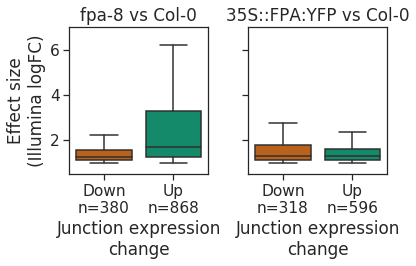

In [48]:
fpa_sig_junc = fpa_vs_col0_junc.query('fdr < 0.05 & gene_level_fdr < 0.05 & abs(logfc) > 1')
FPAox_sig_junc = FPAox_vs_col0_junc.query('fdr < 0.05 & gene_level_fdr < 0.05 & abs(logfc) > 1')

fig, axes = plt.subplots(figsize=(6, 4), ncols=2, sharey=True)

sns.boxplot(
    x=fpa_sig_junc.logfc > 0,
    y=fpa_sig_junc.logfc.abs(),
    ax=axes[0],
    palette=pal[1:3],
    fliersize=0
)

sns.boxplot(
    x=FPAox_sig_junc.logfc > 0,
    y=FPAox_sig_junc.logfc.abs(),
    ax=axes[1],
    palette=pal[1:3],
    fliersize=0
)

axes[0].set_title('fpa-8 vs Col-0')
axes[1].set_title('35S::FPA:YFP vs Col-0')
axes[0].set_ylim(0.5, 7)
axes[0].set_ylabel('Effect size\n(Illumina logFC)')
axes[1].set_ylabel('')
axes[0].set_xticklabels([f'Down\nn={len(fpa_sig_junc.query("logfc < 0"))}',
                         f'Up\nn={len(fpa_sig_junc.query("logfc > 0"))}'])
axes[1].set_xticklabels([f'Down\nn={len(FPAox_sig_junc.query("logfc < 0"))}',
                         f'Up\nn={len(FPAox_sig_junc.query("logfc > 0"))}'])
axes[0].set_xlabel('Junction expression\nchange')
axes[1].set_xlabel('Junction expression\nchange')
plt.tight_layout()
plt.savefig('Illumina_differentially_expressed_junctions.svg')
plt.show()

In [42]:
def get_gtf_attribute(gtf_record, attribute):
    try:
        attr = re.search(f'{attribute} "(.+?)";', gtf_record[8]).group(1)
    except AttributeError:
        raise ValueError(
            f'Could not parse attribute {attribute} '
            f'from GTF with feature type {record[2]}'
        )
    return attr


locus2gene = defaultdict(set)
with open('../../nanopore_apa_pipeline/pipeline/assembly/merged_nanopore_assembly.gtf') as gtf:
    for record in gtf:
        record = record.split('\t')
        if record[2] == 'transcript':
            locus_id = get_gtf_attribute(record, 'locus')
            gene_id = get_gtf_attribute(record, 'gene_id')
            if re.match('AT[1-5]G\d{5}', gene_id):
                locus2gene[locus_id].add(gene_id)


n_genes_per_loci = {locus_id: len(genes) for locus_id, genes in locus2gene.items()}

In [43]:
(fpa_sig_junc.locus_id.map(n_genes_per_loci).fillna(0) > 1).sum() / len(fpa_sig_junc)

0.16185897435897437

In [44]:
(fpa_vs_col0_junc.locus_id.map(n_genes_per_loci).fillna(0) > 1).sum() / len(fpa_vs_col0_junc)

0.04637600666481533